In [1]:
## import libraries
import numpy as np
import pandas as pd
import utils
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from math import sqrt
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from bs4 import BeautifulSoup
import requests
import lxml
import datetime
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from pybaseball import batting_stats_bref
from pybaseball import statcast_batter_expected_stats
from pybaseball import statcast_pitcher_expected_stats
from pybaseball import pitching_stats
from pybaseball import cache
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pd.options.display.max_columns = None
cache.enable()



In [2]:
# functions



# get today's date formatted as yyyy-mm-dd
def get_todays_date():
  # get the current date
  today = datetime.date.today()
  # format the date as yyyy-mm-dd
  date = today.strftime('%Y-%m-%d')
  # return the date
  return date

def get_starters(date):
  # url for the website
  url = 'https://www.fangraphs.com/livescoreboard.aspx?date=' + date
  # get the website with bs
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  tables = soup.find_all('table', class_='lineup')

  starting = []
  for table in tables:
    row = table.find_all('tr')
    for r in row:
      col = r.find_all('td')
      for c in col:
        a = c.find_all('a')
        if len(a) > 0:
          for i in a:
            name = i.text
            # change names which are not in the correct format
            if name == 'Cedric Mullins II':
              starting.append('Cedric Mullins')
            elif name == 'Mike Siani':
              starting.append('Michael Siani')
            elif name == 'Enrique Hernandez':
              starting.append('Kike Hernandez')
            elif name == 'J.J. Bleday':
              starting.append('JJ Bleday')
            elif name == 'D.J. Stewart':
              starting.append('DJ Stewart')
            else:
              starting.append(name)


  starting_df = pd.DataFrame(starting)
  return starting_df

            
def calculate_batting_fantasy_points(row):
  points = 0
  if row['events']=='single' or row['events'] == 'walk':
    points = points + 3
  elif row['events']=='double':
    points = points + 5
  elif row['events']=='triple':
    points = points + 8
  elif row['events']=='home_run':
    points = points + 10

  points = points + 4 * (row['post_bat_score']- row['bat_score'])

  return points

def calculate_pitching_fantasy_points(row):
  points = 0
  if row['events']=='strikeout':
    points = points + 2.75
  elif row['events']=='double_play' or row['events']=='grounded_into_double_play':
    points = points + 1.5
  elif row['events']=='strikeout_double_play' or row['events']=='strikeout_double_play':
    points = points + 3.5
  elif row['events']=='triple_play':
    points = points + 2.25
  elif row['events']=='single' or row['events'] == 'walk' or row['events'] == 'hit_by_pitch' or row['events'] == 'double' or row['events'] == 'triple' or row['events'] == 'home_run':
    points = points - .6
  else:
    points = points + .75

  points = points - 2 * (row['post_bat_score']- row['bat_score'])
  return points

def total_ball_movement(row):
  return sqrt(row['pfx_x']**2 + row['pfx_z']**2)

def batter_adjusted_plate_x(row):
  if row['stand'] == 'R':
    return row['plate_x']
  else:
    return -row['plate_x']

# sum batter stats per team for each game
def team_batters_games(df):
  df['team'] = df.apply(team, axis=1)
  team_batters = df.groupby(['game_pk', 'team'])['batter_fp'].sum().reset_index()
  return team_batters
    
# determine team based on inning_topbot
def team(row):
  if row['inning_topbot'] == 'Top':
    return row['away_team']
  else:
    return row['home_team']
  
# sum pitcher stats per team for each game
def team_pitchers_games(df):
  df['team'] = df.apply(team, axis=1)
  team_pitchers = df.groupby(['game_pk', 'team', 'player_name'])['pitcher_fp'].sum().reset_index()
  # get batters faced per pitcher
  batters_faced = df.groupby(['game_pk', 'team', 'player_name'])['batter'].count().reset_index()
  # merge the two dataframes
  team_pitchers = pd.merge(team_pitchers, batters_faced, on=['game_pk', 'team', 'player_name'])
  # for each game, select the pitcher with the most batters faced
  team_pitchers = team_pitchers.sort_values(by=['game_pk', 'batter'], ascending=False).drop_duplicates(subset=['game_pk', 'team'])
  return team_pitchers

# batter fantasy points by game
def batter_fp(df):
  df['batter_fp'] = df.apply(calculate_batting_fantasy_points, axis=1)
  batter_game_fp = df.groupby(['game_pk', 'batter'])['batter_fp'].sum().reset_index()
  return batter_game_fp

# get number of plate appearances for each batter
def get_plate_appearances(df):
  plate_appearances = df.groupby(['batter'])['batter'].count().reset_index(name='pa')
  return plate_appearances

# filter the df to only the last x days
def last_x_days(df, x):
  # get the current date
  today = datetime.date.today()
  # get the date x days ago
  x_days_ago = today - datetime.timedelta(days=x)
  # convert to date
  x_days_ago = x_days_ago.strftime('%Y-%m-%d')
  # filter the df to only the last x days
  df = df[df['game_date'] > x_days_ago]
  return df

# fix player names to remove latin characters
def fix_player_names(df, column_name):
  df[column_name] = df[column_name].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  return df

# fix players names to move first name to the front and remove commas
def fix_player_names2(df, column_name):
  df[column_name] = df[column_name].str.split(',').str[1] + ' ' + df[column_name].str.split(',').str[0]
  return df

# get the frequency that a player has a stat between two values
def player_stat_frequency(df, player_name, column_name, lower, upper, is_batter=True):
  # filter the df to the selected player depending on if they are a batter or pitcher
  if is_batter:
    df = df[df['batter'] == player_name]
  else:
    df = df[df['player_name'] == player_name]

  # fix for when tyring to divide by zero
  if df.shape[0] == 0:
    return 0
  # find how often column name is between lower and upper
  freq = df[(df[column_name] >= lower) & (df[column_name] <= upper)].shape[0] / df.shape[0]
  return freq

# reformatting for merge
def convert_to_player_name(row):
  name = row['Name']
  # handle case for names with two spaces
  if len(name.split(' ')) > 2:
    return  name.split(' ')[1] + ' ' + name.split(' ')[2] + ', ' + name.split(' ')[0]
  else:
    return name.split(' ')[1] + ', ' + name.split(' ')[0]
    
# get data before date x
def data_before_date(df, y, m, d):
  x = y + "-" + m + "-" + d
  # filter the df to only the last x days
  df = df[df['game_date'] < x]
  return df


def get_batter_game_fp(pregame_info):
    # batter game fp
    batter_game_fp = batter_fp(pregame_info) # replaced batter_recent_info with df

    # get plate appearances for each batter
    plate_appearances = get_plate_appearances(pregame_info) # replaced batter_recent_info with df

    # get batter names
    batter_ids = batter_game_fp['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

    # rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge batter names with batter game fp and plate_appearances
    batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
    batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

    # filter out batters with less than 14 plate appearances
    batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

    # get 25th and 75th percentile outcomes for batter_fp for batters
    batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
    batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
    batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
    batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
    batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)
    return batter_game_fp

def get_pitcher_exp(pregame_info):
    # get all qualified pitchers in 2024
    pitcher_exp = pitching_stats(2024, qual=10)
    pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

    # apply convert_to_player_name to Name column
    pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    # get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
    pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_speed', 100, 109, is_batter=False), axis=1)
    pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)
    return pitcher_exp

def get_batter_exp(pregame_info):
    # get all of this season's expected batting data so far
    batter_exp = statcast_batter_expected_stats(2024)
    batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
    batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
    # rename first column to batter_name and player_id to batter
    batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
    batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

    # get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
    batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_speed', 100, 150), axis=1)
    batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_angle', 25, 31.25), axis=1)
    return batter_exp


def get_pregame_batting_order(pregame_info):
    # get only the first at bat for each batter per game
    pregame_batting_order = pregame_info.sort_values(by=['game_pk', 'at_bat_number'])
    pregame_batting_order = pregame_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    pregame_batting_order["batting_order"] = pregame_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    pregame_batting_order = pregame_batting_order[pregame_batting_order['batting_order'] <= 9]
    return pregame_batting_order

def trim(col):
    return col.str.strip()

In [104]:
# get starters and convert starters to csv
starting_df = get_starters(get_todays_date())
starting_df.to_csv('C:\\Users\\jorda\\Downloads\\starting_lineups.csv', index=False)

In [4]:
# get base df

# Get all Statcast data from 2024
df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# Only include events
df = df.dropna(subset=['events']).dropna(subset=['pitch_type'])
df = fix_player_names(df, 'player_name')

# get more info
df['pitcher_fp'] = df.apply(lambda row: calculate_pitching_fantasy_points(row), axis=1)
df['batter_fp'] = df.apply(lambda row: calculate_batting_fantasy_points(row), axis=1)
df['total_ball_movement'] = df.apply(lambda row: total_ball_movement(row), axis=1)
df['batter_adjusted_plate_x'] = df.apply(lambda row: batter_adjusted_plate_x(row), axis=1)

# get team batters
team_batters = team_batters_games(df)

# get team pitchers
team_pitchers = team_pitchers_games(df)

# get game_pks and game_dates
game_info = df[['game_pk', 'game_date', 'away_team', 'home_team']].drop_duplicates()

# combine team batters and team pitchers
team_stats = pd.merge(team_batters, team_pitchers, on=['game_pk', 'team'])
# merge with game info
team_stats = pd.merge(team_stats, game_info, on='game_pk')
team_stats.head()

# get 75th percentile outcomes for batter_fp and pitcher_fp for pitchers and teams
team_stats['batter_fp'] = team_stats['batter_fp'].astype(float)
team_stats['pitcher_fp'] = team_stats['pitcher_fp'].astype(float)

# use a dataframe for team-based stats that only uses data from the last 10 days
team_info_df = last_x_days(team_stats, 10)
team_info_df['team_fp_75'] = team_info_df.groupby('team')['batter_fp'].transform(lambda x: x.quantile(.75))
team_info_df['opp_pitcher_fp_75'] = team_info_df.groupby('team')['pitcher_fp'].transform(lambda x: x.quantile(.75))
team_info_df['team_fp_75'] = team_info_df['team_fp_75'].fillna(0)
team_info_df['opp_pitcher_fp_75'] = team_info_df['opp_pitcher_fp_75'].fillna(0)

# pitchers can have full season stats
team_stats['pitcher_fp_75'] = team_stats.groupby('player_name')['pitcher_fp'].transform(lambda x: x.quantile(.75))
team_stats['opp_team_fp_75'] = team_stats.groupby('player_name')['batter_fp'].transform(lambda x: x.quantile(.75))
team_stats['pitcher_fp_75'] = team_stats['pitcher_fp_75'].fillna(0)
team_stats['opp_team_fp_75'] = team_stats['opp_team_fp_75'].fillna(0)

# separate teams and pitchers 75th percentiles, and drop duplicates
pitcher_outliers = team_stats[['player_name', 'pitcher_fp_75', 'opp_team_fp_75']].drop_duplicates()
pitcher_outliers = fix_player_names(pitcher_outliers, 'player_name')
team_outliers = team_info_df[['team', 'team_fp_75', 'opp_pitcher_fp_75']].drop_duplicates()

# change team from AZ to ARI and WSH to WAS
team_outliers['team'] = team_outliers['team'].replace({'AZ': 'ARI', 'WSH': 'WAS'})

#pitcher_outliers.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_outliers.csv', index=False)
team_outliers.to_csv('C:\\Users\\jorda\\Downloads\\team_outliers.csv', index=False)

# use last_x_days to filter df for recency
# batter_recent_info = last_x_days(df, 10)

# finding recency bias to be problematic, so we will use all data

# batter game fp
batter_game_fp = batter_fp(df) # replaced batter_recent_info with df

# get plate appearances for each batter
plate_appearances = get_plate_appearances(df) # replaced batter_recent_info with df

# get batter names
batter_ids = batter_game_fp['batter'].unique()
batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

# rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

# merge batter names with batter game fp and plate_appearances
batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

# filter out batters with less than 14 plate appearances
batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

# get 25th and 75th percentile outcomes for batter_fp for batters
batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)

# select only batter_name and batter_fp_75 and drop duplicates
batter_outliers = batter_game_fp[['batter_name', 'batter_fp_25', 'batter_fp_75', 'batter']].drop_duplicates()
# batter_outliers.to_csv('C:\\Users\\jorda\\Downloads\\batter_outliers.csv', index=False)



# get data for all qualified pitchers in 2024
pitcher_exp = pitching_stats(2024, qual=10)
pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

# apply convert_to_player_name to Name column
pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

# get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_speed', 100, 109, is_batter=False), axis=1)
pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)


# merge with pitcher_outliers
pitcher_exp = pd.merge(pitcher_exp, pitcher_outliers, on='player_name')
pitcher_exp.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_exp.csv', index=False)


# get all of this season's expected batting data so far
batter_exp = statcast_batter_expected_stats(2024)
batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
# rename first column to batter_name and player_id to batter
batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

# get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_speed', 100, 150), axis=1)
batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_angle', 25, 31.25), axis=1)
# merge with batter_outliers

batter_exp = pd.merge(batter_exp, batter_outliers, on='batter')
batter_exp.to_csv('C:\\Users\\jorda\\Downloads\\batter_exp.csv', index=False)

# summarize df
batter_summary = batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()

# get only the first at bat for each batter per game
batting_order = df.sort_values(by=['game_pk', 'at_bat_number'])
batting_order = batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
batting_order["batting_order"] = batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
batting_order = batting_order[batting_order['batting_order'] <= 9]

pitcher_exp["player_name"] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

model_data = pd.merge(batter_summary, batting_order, on=['game_pk', 'batter'])
model_data = pd.merge(model_data, batter_exp, on='batter')
model_data = pd.merge(model_data, pitcher_exp, on='player_name')

pitcher_summary = df.groupby(['game_pk', 'player_name'])['pitcher_fp'].sum().reset_index()
model_data = pd.merge(model_data, pitcher_summary, on=['game_pk', 'player_name'])

This is a large query, it may take a moment to complete


 87%|████████▋ | 55/63 [00:01<00:00, 51.66it/s]C:\Users\jorda\AppData\Roaming\Python\Python312\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|██████████| 63/63 [00:10<00:00,  6.03it/s]
C:\Users\jorda\AppData\Roaming\Python\Python312\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)
C:\Users\jorda\AppData\Local\Temp\ipykernel_26836\669524279.py:37: S

In [ ]:
# get mean pitch coordinates
mean_pitch_coordinates = df.groupby(['pitcher', 'player_name'])[['plate_x', 'plate_z', 'batter_adjusted_plate_x']].mean()
mean_pitch_coordinates.rename(columns={'plate_x':'mean_pitcher_plate_x', 'plate_z':'mean_pitcher_plate_z', 'batter_adjusted_plate_x':'mean_pitcher_batter_adjusted_plate_x'}, inplace=True)
mean_pitch_coordinates.to_csv("C:\\Users\\jorda\\Downloads\\pitch_coordinates.csv")
mean_pitch_coordinates.head()

Analysis of Past Slates

In [26]:
# get draftkings salaries based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLBMMDDYYYY.csv"
def get_pregame_info(df, year, month, day):
    pregame_info = data_before_date(df, year, month, day)

    pregame_batter_game_fp = get_batter_game_fp(pregame_info)
    pregame_pitcher_exp = get_pitcher_exp(pregame_info)
    pregame_batter_exp = get_batter_exp(pregame_info)

    # summarize df
    pregame_batter_summary = pregame_batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()


    pregame_batting_order = get_pregame_batting_order(pregame_info)

    # get batter, game_pk, and batting order from pregame_batting_order
    pregame_batting_order = get_pregame_batting_order(pregame_info)
    pregame_batting_order = pregame_batting_order[['batter', 'game_pk', 'batting_order', 'player_name']]

    # merge all pregame data
    pregame_data = pd.merge(pregame_batter_summary, pregame_batting_order, on=['game_pk', 'batter'])
    pregame_data = pd.merge(pregame_data, pregame_batter_exp, on='batter')

    pregame_data = pd.merge(pregame_data, pregame_pitcher_exp, on='player_name')

    # add pitcher_fp to pregame_data
    pregame_data = pd.merge(pregame_data, pitcher_summary, on=['game_pk', 'player_name'])

    return pregame_data

def get_dk_salaries(year, month, day, optional=""):
    salaries = pd.read_csv("C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\DKSalariesMLB" + month + day + year + optional + ".csv")
    return salaries

# get contest standings based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandingsMMDDYYYY.csv"
def get_contest_standings(year, month, day):
    contest_data = pd.read_csv("C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\MLBContestStandings" + month + day + year + ".csv")
    return contest_data

def get_contest_results(contest_data):
    contest_player_results = contest_data[['Player', '%Drafted', 'FPTS']]
    # drop nas
    contest_player_results = contest_player_results.dropna()
    # convert %Drafted to a float
    contest_player_results['%Drafted'] = contest_player_results['%Drafted'].str.replace('%', '').astype(float)
    # convert FPTS to a float
    contest_player_results['FPTS'] = contest_player_results['FPTS'].astype(float)
    return contest_player_results

def get_leaderboard(contest_data):
    leaderboard = contest_data[['Rank', 'Points', 'Lineup']]
    leaderboard = leaderboard.dropna()
    # convert Points to a float
    leaderboard['Points'] = leaderboard['Points'].astype(float)
    return leaderboard


In [6]:
def compile_data_from_date(df, year, month, day):
    # merge dk salaries with pregame_data by batter_name
    salaries = get_dk_salaries(year, month, day, "")

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # only keep Name and Salary for pitchers
    pitcher_salaries = pitcher_salaries[['Name', 'Salary']]
    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
    hitter_salaries.head()

    this_day_statcast = statcast(start_dt=year + '-' + month + '-' + day, end_dt=year + '-' + month + '-' + day)
    # set 'team' as home_team if inning_topbot is 'Bot', and away_team if 'Top'
    this_day_statcast['team'] = this_day_statcast.apply(team, axis=1)
    # get only the first at bat for each batter per game
    this_day_batting_order = this_day_statcast.sort_values(by=['game_pk', 'at_bat_number'])
    this_day_batting_order = this_day_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    this_day_batting_order["batting_order"] = this_day_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    this_day_batting_order = this_day_batting_order[this_day_batting_order['batting_order'] <= 9]

    # get batter_name for this_day_batting_order
    batter_ids = this_day_batting_order['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge this_day_batting_order with batter_name_id_pairs
    this_day_batting_order = pd.merge(this_day_batting_order, batter_name_id_pairs, on='batter')

    # get pitcher_name for this_day_batting_order based on player_name
    this_day_batting_order = fix_player_names(this_day_batting_order, 'player_name')
    this_day_batting_order= fix_player_names2(this_day_batting_order, 'player_name')
    # rename player_name to Name
    this_day_batting_order = this_day_batting_order.rename(columns={'player_name': 'Name'})
    # merge with pitcher_salaries
    bo_with_salaries = pd.merge(this_day_batting_order, hitter_salaries)
    # only keep Name, team, batting_order, batter_name, Roster Position, Salary
    bo_with_salaries = bo_with_salaries[['Name', 'team', 'batting_order', 'batter_name', 'Roster Position', 'Salary']]
    bo_with_salaries = bo_with_salaries.rename(columns={'Salary': 'batter_salary'})
    bo_with_salaries = bo_with_salaries.rename(columns={'Name': 'pitcher_name'})
    # trim pitcher_name in bo_with_salaries
    bo_with_salaries['pitcher_name'] = trim(bo_with_salaries['pitcher_name'])
    # merge with pitcher_salaries
    new_merge = pd.merge(bo_with_salaries, pitcher_salaries, on='pitcher_name')


    # use historic data to determine hitter and pitcher quality, with the goal of predicting batter_fp and pitcher_fp
    pregame_data = get_pregame_info(df, year, month, day)

    # find average batting order and other batting metrics for each player
    pregame_batter_game_fp_mean = pregame_data[['batter_name', 'batting_order', 'batter_fp']]
    pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.groupby('batter_name').mean()
    pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.rename(columns={'batting_order': 'avg_batting_order', 'batter_fp': 'avg_batter_fp'})
    # merge the two dataframes
    pregame_data = pd.merge(pregame_data, pregame_batter_game_fp_mean, on='batter_name')
    # add a column for the change in batting order
    pregame_data['batting_order_change'] = pregame_data['avg_batting_order'] - pregame_data['batting_order']

    # establish a model for each batter depending on the quality of pitcher they are facing
    batter_model = LinearRegression()
    # select only the relevant columns
    batter_model_data = pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
    # set target as batter_fp
    target = pregame_data['batter_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(batter_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    batter_model.fit(X_train, y_train)
    # predict the model
    y_pred = batter_model.predict(X_test)
    # calculate r2 and rmse
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print('Batter Model R2: ', r2)
    print('Batter Model RMSE: ', rmse)


    # establish a model for each pitcher depending on the quality of the batters they are facing
    pitcher_model = LinearRegression()
    # select only the relevant columns
    pregame_pitcher_data = pregame_data[['player_name', 'game_pk', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp']]
    # group by Name and game_pk and use mean for each column
    pregame_pitcher_data = pregame_pitcher_data.groupby(['player_name', 'game_pk']).mean().reset_index()
    # select only the relevant columns
    pitcher_model_data = pregame_pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # set target as pitcher_fp
    target = pregame_pitcher_data['pitcher_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(pitcher_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    pitcher_model.fit(X_train, y_train)
    # predict the model
    y_pred = pitcher_model.predict(X_test)
    # calculate r2 and rmse
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print('Pitcher Model R2: ', r2)
    print('Pitcher Model RMSE: ', rmse)

    # get pitcher names, plus WHIP, Pitching+
    pitcher_names = pregame_data[['player_name', 'WHIP', 'Pitching+', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # rename player_name to pitcher_name
    pitcher_names = pitcher_names.rename(columns={'player_name': 'pitcher_name'})
    # fix names
    pitcher_names = fix_player_names(pitcher_names, 'pitcher_name')
    pitcher_names = fix_player_names2(pitcher_names, 'pitcher_name')
    # trim names
    pitcher_names['pitcher_name'] = trim(pitcher_names['pitcher_name'])
    # drop duplicates
    pitcher_names = pitcher_names.drop_duplicates()
    # get batter names, plus 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'avg_batting_order', 'avg_batter_fp'
    batter_names = pregame_data[['batter_name', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'avg_batting_order', 'avg_batter_fp']]
    # trim names
    batter_names['batter_name'] = trim(batter_names['batter_name'])
    # drop duplicates
    batter_names = batter_names.drop_duplicates()

    # merge with new_merge by names to set up predictions
    all_data = pd.merge(new_merge, pitcher_names, on='pitcher_name')
    all_data = pd.merge(all_data, batter_names, on='batter_name')

    # add batting_order_change to df
    all_data['batting_order_change'] = all_data['avg_batting_order'] - all_data['batting_order']

    # predict batter_fp and pitcher_fp for all_data
    all_data['batter_fp_pred'] = batter_model.predict(all_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])

    # get only one row for each pitcher_name by taking the mean of relevant columns
    pitcher_data = all_data[['pitcher_name', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    pitcher_data = pitcher_data.groupby('pitcher_name').mean().reset_index()
    # predict pitcher_fp for pitcher_data
    pitcher_data['pitcher_fp_pred'] = pitcher_model.predict(pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']])

    # select only pitcher_name and pitcher_fp_pred, then merge with all_data
    pitcher_data = pitcher_data[['pitcher_name', 'pitcher_fp_pred']]
    all_data = pd.merge(all_data, pitcher_data, on='pitcher_name')

    # use leaderboard and results to determine the success of each player
    contest_data = get_contest_standings(year, month, day)
    contest_player_results = get_contest_results(contest_data)
    leaderboard = get_leaderboard(contest_data)

    # Establish payoffs for each player based on their performance as well as their appearance in the leaderboard's top 100
    # get the top 20 lineups
    top_20 = leaderboard.head(20)
    # get all players in the all_data dataframe
    all_players = all_data['batter_name'].unique()
    # get pitchers as well
    pitchers = all_data['pitcher_name'].unique()
    # combine those vectors
    all_players = np.concatenate((all_players, pitchers))

    # enumerate payoffs for placements in the top 20
    payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]

    # create a dictionary for player payoffs
    player_payoffs = {}

    # for each lineup in top_20, look for each player in all_players and increase their payoff by the corresponding value in payoffs if found
    for index, row in top_20.iterrows():
        lineup = row['Lineup']
        for player in all_players:
            if player in lineup:
                if player in player_payoffs:
                    player_payoffs[player] += payoffs[index]
                else:
                    player_payoffs[player] = payoffs[index]

    # for each player in all_players, if they are not in player_payoffs, set their payoff to 0
    for player in all_players:
        if player not in player_payoffs:
            player_payoffs[player] = 0

    # add player payoffs to all_data
    all_data['payoff'] = all_data['batter_name'].map(player_payoffs)

    # add pitcher payoffs to all_data
    all_data['pitcher_payoff'] = all_data['pitcher_name'].map(player_payoffs)


    # add contest results to all_data
    all_data_with_results = pd.merge(all_data, contest_player_results, left_on='batter_name', right_on='Player', how='left')
    # rename %drafted to batter_drafted and FPTS to batter_fpts
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'batter_drafted', 'FPTS': 'batter_fpts'})
    # drop Player column
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # do the same for pitchers
    all_data_with_results = pd.merge(all_data_with_results, contest_player_results, left_on='pitcher_name', right_on='Player', how='left')
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'pitcher_drafted', 'FPTS': 'pitcher_fpts'})
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # add a column for team_batter_fp_pred
    team_batter_fp_pred = all_data_with_results.groupby('team')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data_with_results = pd.merge(all_data_with_results, team_batter_fp_pred, on='team')

    # add a column for teams_in_game_pk
    teams_in_game_pk = all_data_with_results['team'].unique()
    all_data_with_results['teams_in_game_pk'] = teams_in_game_pk.size

    return all_data_with_results


In [ ]:
# run compile_data_from_date for all dates between 5/23/2024 and 5/28/2024, and combine the results into a single dataframe
all_data = pd.DataFrame()
year = '2024'
month = '05'
for i in range(23, 29):
    day = str(i)
    all_data = pd.concat([all_data, compile_data_from_date(df, year, month, day)])

# drop NaNs
all_data = all_data.dropna()
# add a column with value 1 if Roster Position contains OF or /
all_data['is_of'] = all_data['Roster Position'].str.contains('OF|/').astype(int)


In [8]:
# save all_data to csv in case of loss
all_data.to_csv('C:\\Users\\jorda\\Downloads\\all_data.csv', index=False)

In [75]:
X = all_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']]
y = all_data['batter_drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# build a linear regression model to predict the ownership of each batter
model_batter_drafted = LinearRegression()
model_batter_drafted.fit(X_train, y_train)
y_pred = model_batter_drafted.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Ownership Model R2: ', r2)
print('Ownership Model RMSE: ', rmse)


Ownership Model R2:  0.5892760666271263
Ownership Model RMSE:  3.842802957241092


In [10]:
# create a copy of all_data and add the predicted ownership to it
all_data_with_ownership = all_data.copy()
all_data_with_ownership['batter_drafted_pred'] = model_batter_drafted.predict(X)
all_data_with_ownership['batter_drafted_pred'] = all_data_with_ownership['batter_drafted_pred']
all_data_with_ownership.head()

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,avg_batting_order,avg_batter_fp,batting_order_change,batter_fp_pred,pitcher_fp_pred,payoff,pitcher_payoff,batter_drafted,batter_fpts,pitcher_drafted,pitcher_fpts,team_batter_fp_pred,teams_in_game_pk,is_of,batter_drafted_pred
0,Jack Flaherty,TOR,6.0,George Springer,OF,4000,8400,1.08,104,0.119266,0.059633,0.306,0.369,0.249,0.156757,0.075676,1.487805,5.170732,-4.512195,4.921023,18.840052,4500,5000,15.20,2.0,57.42,21.45,24.925484,4,1,10.402836
1,Jack Flaherty,TOR,7.0,Daulton Varsho,OF,4400,8400,1.08,104,0.119266,0.059633,0.276,0.340,0.183,0.105263,0.064327,5.095238,7.785714,-1.904762,7.586522,18.840052,26200,5000,13.47,16.0,57.42,21.45,24.925484,4,1,12.690876
2,Kevin Gausman,DET,2.0,Matt Vierling,3B/OF,3700,8000,1.43,107,0.178010,0.078534,0.316,0.424,0.274,0.210884,0.054422,3.656250,6.843750,1.656250,7.275932,11.129211,0,101100,32.56,3.0,52.82,32.50,35.774217,4,1,21.038338
3,Jack Flaherty,TOR,4.0,Bo Bichette,SS,4600,8400,1.08,104,0.119266,0.059633,0.311,0.401,0.264,0.235294,0.032086,3.355556,6.155556,-0.644444,5.651645,18.840052,87900,5000,23.32,13.0,57.42,21.45,24.925484,4,0,15.910601
4,Jack Flaherty,TOR,1.0,Davis Schneider,2B/OF,4200,8400,1.08,104,0.119266,0.059633,0.342,0.425,0.223,0.160839,0.055944,4.454545,7.424242,3.454545,6.766294,18.840052,900,5000,28.64,2.0,57.42,21.45,24.925484,4,1,17.991613


In [88]:
pregame_data = get_pregame_info(df, '2024', '05', '29')

# get avg_batter_fp and batting_order_change for each player
pregame_batter_game_fp_mean = pregame_data[['batter_name', 'batting_order', 'batter_fp']]
pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.groupby('batter_name').mean()
pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.rename(columns={'batting_order': 'avg_batting_order', 'batter_fp': 'avg_batter_fp'})
# merge the two dataframes
pregame_data = pd.merge(pregame_data, pregame_batter_game_fp_mean, on='batter_name')
# add a column for the change in batting order
pregame_data['batting_order_change'] = pregame_data['avg_batting_order'] - pregame_data['batting_order']


# establish a model for each batter depending on the quality of pitcher they are facing
batter_model = LinearRegression()
# select only the relevant columns
batter_model_data = pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
# set target as batter_fp
target = pregame_data['batter_fp']
# split the data
X_train, X_test, y_train, y_test = train_test_split(batter_model_data, target, test_size=0.2, random_state=0)
# fit the model
batter_model.fit(X_train, y_train)
# predict the model
y_pred = batter_model.predict(X_test)
# calculate r2 and rmse
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Batter Model R2: ', r2)
print('Batter Model RMSE: ', rmse)

C:\Users\jorda\AppData\Local\Temp\ipykernel_26836\41115661.py:244: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pregame_batting_order = pregame_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)


Batter Model R2:  0.04584181097834328
Batter Model RMSE:  7.166223788826258


C:\Users\jorda\AppData\Local\Temp\ipykernel_26836\41115661.py:244: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pregame_batting_order = pregame_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)


In [81]:
# establish a model for each pitcher depending on the quality of the batters they are facing
pitcher_model = LinearRegression()
# select only the relevant columns
pregame_pitcher_data = pregame_data[['player_name', 'game_pk', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp']]
# group by Name and game_pk and use mean for each column
pregame_pitcher_data = pregame_pitcher_data.groupby(['player_name', 'game_pk']).mean().reset_index()
# select only the relevant columns
pitcher_model_data = pregame_pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
# set target as pitcher_fp
target = pregame_pitcher_data['pitcher_fp']
# split the data
X_train, X_test, y_train, y_test = train_test_split(pitcher_model_data, target, test_size=0.2, random_state=0)
# fit the model
pitcher_model.fit(X_train, y_train)
# predict the model
y_pred = pitcher_model.predict(X_test)
# calculate r2 and rmse
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Pitcher Model R2: ', r2)
print('Pitcher Model RMSE: ', rmse)

Pitcher Model R2:  0.14369719294259697
Pitcher Model RMSE:  8.989679153718054


In [11]:
# reduce df to pitcher name, batter_salary, pitcher_salary, WHIP, Pitching+, team, pitcher_fp_pred, pitcher_drafted, team_batter_fp_pred, and teams_in_game_pk; get sum of batter_salary and mean of everything else
pitcher_data = all_data_with_ownership[['pitcher_name', 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'team', 'pitcher_fp_pred', 'pitcher_drafted', 'team_batter_fp_pred', 'teams_in_game_pk']]
pitcher_data = pitcher_data.groupby(['pitcher_name', 'pitcher_drafted']).agg({'batter_salary': 'sum', 'pitcher_salary': 'mean', 'WHIP': 'mean', 'Pitching+': 'mean', 'pitcher_fp_pred': 'mean', 'team_batter_fp_pred': 'mean', 'teams_in_game_pk': 'mean'}).reset_index()
# merge this with unique pitcher_name and pitcher_drafted
pitcher_data.head()

,pitcher_name,pitcher_drafted,batter_salary,pitcher_salary,WHIP,Pitching+,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk
0,Alec Marsh,7.57,30300,8000.0,1.06,100.0,16.394470,47.409743,13.0
1,Bailey Ober,8.91,30800,8300.0,1.04,103.0,15.258564,44.119731,20.0
2,Ben Brown,3.27,39700,7300.0,1.19,100.0,11.464535,66.615323,19.0
3,Brandon Pfaadt,4.97,29800,7600.0,1.08,106.0,15.189376,44.398635,19.0
4,Braxton Garrett,10.82,20300,5800.0,1.02,94.0,14.616244,32.731879,20.0


In [76]:
# linear regression model to predict pitcher_drafted
X = pitcher_data[['batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']]
y = pitcher_data['pitcher_drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model_pitcher_drafted = LinearRegression()
model_pitcher_drafted.fit(X_train, y_train)
y_pred = model_pitcher_drafted.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Pitcher Ownership Model R2: ', r2)
print('Pitcher Ownership Model RMSE: ', rmse)


Pitcher Ownership Model R2:  0.4590646022105138
Pitcher Ownership Model RMSE:  10.694111697443637


In [13]:
# add pitcher_drafted_pred to all_data_with_ownership
all_data_with_ownership['pitcher_drafted_pred'] = model_pitcher_drafted.predict(all_data_with_ownership[['batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']])



Epoch 1/100


C:\Users\jorda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step - loss: 376503360.0000 - val_loss: 224511552.0000
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 373738016.0000 - val_loss: 223037920.0000
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 371166144.0000 - val_loss: 221757680.0000
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 368824512.0000 - val_loss: 220686912.0000
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 366748864.0000 - val_loss: 219828512.0000
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 364894016.0000 - val_loss: 219152720.0000
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 363242176.0000 - val_loss: 218658624.0000
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 361766080.0000 - val_loss: 218337376.0000
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 360451232.0000 - val_loss: 218146112.0000
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 359294272.0000 - val_loss: 218079104.0000
Epoch 11/1

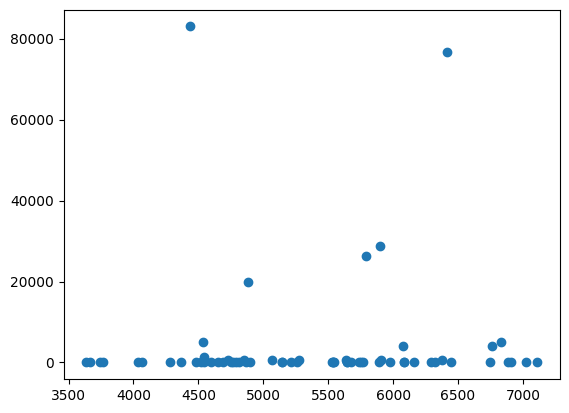

In [77]:
# create a tensorflow model to predict payoff for each player
X = all_data_with_ownership[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred', 'batter_drafted_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'batter_salary']]
y = all_data_with_ownership['payoff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_payoff = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model_payoff.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

history = model_payoff.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=100
)

y_pred = model_payoff.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Payoff Model R2: ', r2)
print('Payoff Model RMSE: ', rmse)

# plot y_pred vs y_test
plt.scatter(y_pred, y_test)



In [15]:
# show which players correspond to the highest predicted payoffs
all_data_with_payoff_pred  = all_data_with_ownership.copy()
all_data_with_payoff_pred['payoff_pred'] = model_payoff.predict(all_data_with_payoff_pred[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred', 'batter_drafted_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'batter_salary']])
all_data_with_payoff_pred = all_data_with_payoff_pred.sort_values(by='payoff_pred', ascending=False)
all_data_with_payoff_pred.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,avg_batting_order,avg_batter_fp,batting_order_change,batter_fp_pred,pitcher_fp_pred,payoff,pitcher_payoff,batter_drafted,batter_fpts,pitcher_drafted,pitcher_fpts,team_batter_fp_pred,teams_in_game_pk,is_of,batter_drafted_pred,pitcher_drafted_pred,payoff_pred
77,Graham Ashcraft,LAD,2.0,Shohei Ohtani,1B/OF,6600,6400,1.44,98,0.196262,0.046729,0.463,0.676,0.350,0.334884,0.060465,1.978261,11.347826,-0.021739,11.752527,7.407957,70400,0,16.82,2.0,2.37,5.40,52.926396,20,1,9.341494,0.285541,9514.038086
8,Yu Darvish,NYY,2.0,Juan Soto,OF,6500,8000,0.99,102,0.107143,0.023810,0.460,0.668,0.321,0.303797,0.063291,2.000000,10.849057,0.000000,9.965211,17.274378,3100,0,3.28,23.0,17.49,2.75,52.051005,20,1,2.742488,7.692528,9261.815430
16,Luis Castillo,HOU,2.0,Kyle Tucker,OF,6500,9200,1.21,104,0.140221,0.062731,0.426,0.588,0.292,0.177966,0.097458,2.796296,11.037037,0.796296,10.997807,13.646735,0,0,2.95,2.0,7.80,17.90,39.250977,19,1,5.618700,16.362768,9024.428711
15,Ross Stripling,HOU,2.0,Kyle Tucker,OF,6400,5600,1.60,99,0.168831,0.069264,0.426,0.588,0.292,0.183486,0.105505,2.860000,11.300000,0.860000,12.358787,6.801027,400,0,7.16,5.0,1.74,-2.55,45.425498,20,1,8.699291,4.270656,8982.084961
61,Cooper Criswell,BAL,1.0,Gunnar Henderson,SS,6300,7800,1.19,102,0.176056,0.063380,0.392,0.544,0.277,0.235556,0.062222,1.120000,10.560000,0.120000,10.491251,12.629198,0,0,6.78,4.0,1.57,-3.20,55.228379,13,0,12.687027,17.996202,8981.174805


In [59]:
year = '2024'
month = '05'
day = '29'
optional = 'b'

# get salaries for today
todays_salaries = get_dk_salaries(year, month, day, optional)

# select Name, Roster Position, Salary, and TeamAbbrev from salaries
salaries = todays_salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]
# fixnames
salaries = fix_player_names(salaries, 'Name')

# remove Jr., Sr., II, and III from names
salaries['Name'] = salaries['Name'].str.replace(' Jr.', '')
salaries['Name'] = salaries['Name'].str.replace(' Sr.', '')
salaries['Name'] = salaries['Name'].str.replace(' II', '')
salaries['Name'] = salaries['Name'].str.replace(' III', '')

# get all players who are not Roster Position P
hitter_salaries = salaries[salaries['Roster Position'] != 'P']

# get all players who are Roster Position P
pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

# rename salary to pitcher_salary
pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

# rename hitter_salaries Name to batter_name
hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
hitter_salaries.reset_index(drop=True, inplace=True)

# get batting orders from get_starters, or by using the last game_pk for the team in df
starters = get_starters(year+'-'+month+'-'+day)





C:\Users\jorda\AppData\Local\Temp\ipykernel_26836\41115661.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
C:\Users\jorda\AppData\Local\Temp\ipykernel_26836\152617234.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaries['Name'] = salaries['Name'].str.replace(' Jr.', '')
C:\Users\jorda\AppData\Local\Temp\ipykernel_26836\152617234.py:16: SettingWithCopyWarning: 
A value is trying to 

In [60]:
# rename starters to batter_name
starters = starters.rename(columns={0: 'batter_name'})

# trim hitter_salaries
hitter_salaries['batter_name'] = trim(hitter_salaries['batter_name'])
# trim starters
starters['batter_name'] = trim(starters['batter_name'])

# remove Jr., Sr., II, and III from names
starters['batter_name'] = starters['batter_name'].str.replace(' Jr.', '')
starters['batter_name'] = starters['batter_name'].str.replace(' Sr.', '')
starters['batter_name'] = starters['batter_name'].str.replace(' II', '')
starters['batter_name'] = starters['batter_name'].str.replace(' III', '')



In [ ]:
starting_hitters_salaries = hitter_salaries[hitter_salaries['batter_name'].isin(starters['batter_name'])]
starting_hitters_bo = starters[starters['batter_name'].isin(hitter_salaries['batter_name'])]
starting_hitters_bo = starting_hitters_bo.reset_index(drop=True)

# add a row to starting_hitters_bo that equals index mod 9 + 1
starting_hitters_bo['batting_order'] = (starting_hitters_bo.index % 9) + 1



In [ ]:
# merge starting_hitters_bo with starting_hitters_salaries
starting_hitters = pd.merge(starting_hitters_bo, starting_hitters_salaries, on='batter_name')



In [72]:

# get all players who are Roster Position P
pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

# rename salary to pitcher_salary
pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

def get_opposing_team(team, game_info):
    # get the opposing team from the game_info
    matchup = game_info.split(' ')[0]
    teams = matchup.split('@')
    if teams[0] == team:
        return teams[1]
    else:
        return teams[0]


# get opposing team from Game Info as team that is not TeamAbbrev
pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)
pitcher_salaries

,Position,Name + ID,pitcher_name,ID,Roster Position,pitcher_salary,Game Info,TeamAbbrev,AvgPointsPerGame,opp_team
0,SP,Shota Imanaga (34401299),Shota Imanaga,34401299,P,10600,CHC@MIL 05/29/2024 07:40PM ET,CHC,24.15,MIL
1,SP,Freddy Peralta (34401800),Freddy Peralta,34401800,P,10600,CHC@MIL 05/29/2024 07:40PM ET,MIL,20.33,CHC
2,SP,Chris Sale (34401801),Chris Sale,34401801,P,10500,WSH@ATL 05/29/2024 07:20PM ET,ATL,26.64,WSH
3,SP,Luis Gil (34401300),Luis Gil,34401300,P,10300,NYY@LAA 05/29/2024 09:38PM ET,NYY,22.89,LAA
4,SP,Cole Ragans (34401802),Cole Ragans,34401802,P,10100,KC@MIN 05/29/2024 07:40PM ET,KC,19.50,MIN
...,...,...,...,...,...,...,...,...,...,...
509,RP,Oliver Ortega (34402176),Oliver Ortega,34402176,P,4000,HOU@SEA 05/29/2024 09:40PM ET,HOU,0.00,SEA
510,RP,Dylan Coleman (34402179),Dylan Coleman,34402179,P,4000,HOU@SEA 05/29/2024 09:40PM ET,HOU,3.65,SEA
511,RP,Trevor Kelley (34402201),Trevor Kelley,34402201,P,4000,HOU@SEA 05/29/2024 09:40PM ET,SEA,0.00,HOU
512,RP,Ty Adcock (34402215),Ty Adcock,34402215,P,4000,HOU@SEA 05/29/2024 09:40PM ET,SEA,0.00,HOU


In [73]:
# keep pitcher_name, pitcher_salary, opp_team
pitcher_salaries = pitcher_salaries[['pitcher_name', 'pitcher_salary', 'opp_team']]

# rename opp_team to team
pitcher_salaries = pitcher_salaries.rename(columns={'opp_team': 'TeamAbbrev'})

# only keep pitchers who are in starters['batter_name']
pitcher_salaries = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(starters['batter_name'])]

# merge starting_hitters with pitcher_salaries on TeamAbbrev
all_players = pd.merge(starting_hitters, pitcher_salaries, on='TeamAbbrev')


In [83]:
all_players


,batter_name,batting_order,Roster Position,Salary,TeamAbbrev,pitcher_name,pitcher_salary
0,CJ Abrams,1,SS,5400,WSH,Spencer Schwellenbach,7500
1,Lane Thomas,2,OF,4100,WSH,Spencer Schwellenbach,7500
2,Jesse Winker,3,OF,3800,WSH,Spencer Schwellenbach,7500
3,Luis Garcia,4,2B,4000,WSH,Spencer Schwellenbach,7500
4,Keibert Ruiz,5,C,2400,WSH,Spencer Schwellenbach,7500
...,...,...,...,...,...,...,...
85,Elehuris Montero,5,1B,3400,COL,Logan Allen,6900
86,Brenton Doyle,6,OF,4200,COL,Logan Allen,6900
87,Jacob Stallings,7,C,4100,COL,Logan Allen,6900
88,Sean Bouchard,8,OF,3700,COL,Logan Allen,6900


In [89]:
# get the data which will be needed to predict the ownerships and payoffs for each player
# for batter_fp_pred, need 'avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq'
# for pitcher_fp_pred, need 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher'
# for batter_drafted_pred, need 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk'
# for pitcher_drafted_pred, need 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk'
# for payoff_pred, need 'avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 
# 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred', 'batter_drafted_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'batter_salary'

batter_data = pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].drop_duplicates()
pitcher_data = pregame_data[['player_name', 'Pitching+', 'WHIP', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']].drop_duplicates()

# rename player_name to pitcher_name
pitcher_data = pitcher_data.rename(columns={'player_name': 'pitcher_name'})

# merge with all_players
all_players_plus_data = pd.merge(all_players, batter_data, on='batter_name')
all_players_plus_data = pd.merge(all_players_plus_data, pitcher_data, on='pitcher_name')

# add a column for the change in batting order
all_players_plus_data['batting_order_change'] = all_players_plus_data['avg_batting_order'] - all_players_plus_data['batting_order']

# predict batter_fp and pitcher_fp for all_players_plus_data
all_players_plus_data['batter_fp_pred'] = batter_model.predict(all_players_plus_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])
all_players_plus_data['pitcher_fp_pred'] = pitcher_model.predict(all_players_plus_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']])

# get team_batter_fp_pred
team_batter_fp_pred = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].sum().reset_index()
team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
all_players_plus_data = pd.merge(all_players_plus_data, team_batter_fp_pred, on='TeamAbbrev')

# get teams_in_game_pk
teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

# predict batter_drafted and pitcher_drafted for all_players_plus_data
all_players_plus_data['batter_drafted_pred'] = model_batter_drafted.predict(all_players_plus_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']])
all_players_plus_data['pitcher_drafted_pred'] = model_pitcher_drafted.predict(all_players_plus_data[['batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']])

# predict payoff for all_players_plus_data
all_players_plus_data['payoff_pred'] = model_payoff.predict(all_players_plus_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred', 'batter_drafted_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'batter_salary']])
all_players_plus_data = all_players_plus_data.sort_values(by='payoff_pred', ascending=False)
all_players_plus_data.head()

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required by LinearRegression.

In [92]:
batter_data = pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].drop_duplicates()
batter_data

,batter_name,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq
0,Eddie Rosario,6.459459,5.486486,0.271,0.366,0.199,0.131579,0.052632
1,Jorge Polanco,5.511111,3.933333,0.278,0.324,0.198,0.116667,0.027778
2,Joey Gallo,5.166667,5.333333,0.282,0.343,0.158,0.117188,0.031250
3,Jesse Winker,6.847826,3.891304,0.335,0.395,0.249,0.150000,0.025000
4,Joey Meneses,6.276596,3.914894,0.295,0.369,0.237,0.178218,0.084158
...,...,...,...,...,...,...,...,...
2497,Ha-Seong Kim,5.584906,6.811321,0.320,0.359,0.245,0.126168,0.079439
2498,Jackson Merrill,6.250000,7.272727,0.346,0.471,0.299,0.219780,0.076923
3190,Jake Bauers,7.931034,5.172414,0.357,0.494,0.255,0.141791,0.067164
4098,David Fry,9.826087,4.434783,0.372,0.414,0.263,0.152000,0.096000
